In [3]:
import sys
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F

sys.path.append('../experiments/SeqVG/')
from net import Encoder, Decoder, Discriminator
%matplotlib inline

In [4]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SeqVG')
MODEL_PATH = ROOT_PATH.joinpath('models/SeqVG')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SeqVG
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SeqVG


In [5]:
test_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_test.npy')) \
              .astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_train.npy')) \
               .astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(1000, 20, 64, 64) float32 1.0
(9000, 20, 64, 64) float32 1.0


In [6]:
encoder = Encoder(64, 1, 100, 8)
decoder = Decoder(64, 1, 100, 8)

chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist_test',
    'Encoder_SeqVG_latent100_ch8_coef11.0_coef10.5.npz'), encoder)
chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist_test',
    'Decoder_SeqVG_latent100_ch8_coef11.0_coef10.5.npz'), decoder)

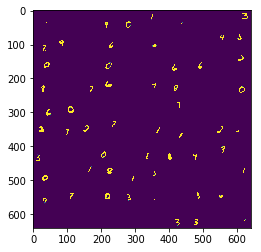

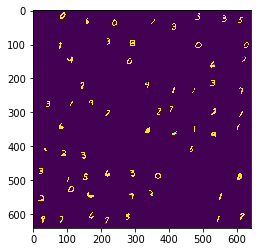

In [7]:
x = train_data[:100, 0,:].reshape(100, 1, 64, 64)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x̃ = (decoder(encoder(x)[0])).array.reshape(10, 10, 64, 64)
x̃ = np.clip(x̃, 0, 1).transpose(0, 2, 1, 3).reshape(640, 640)
plt.imshow(x̃)
plt.show()
Image.fromarray((x̃*255).astype(np.uint8)).save('train_rec.jpeg')
x = x.reshape(10, 10, 64, 64).transpose(0, 2, 1, 3).reshape(640, 640)
Image.fromarray((x*255).astype(np.uint8)).save('train_gt.jpeg')

x = test_data[:100, 0,:].reshape(100, 1, 64, 64)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x̃ = (decoder(encoder(x)[0])).array.reshape(10, 10, 64, 64)
x̃ = np.clip(x̃, 0, 1).transpose(0, 2, 1, 3).reshape(640, 640)
plt.imshow(x̃)
plt.show()
Image.fromarray((x̃*255).astype(np.uint8)).save('test_rec.jpeg')
x = x.reshape(10, 10, 64, 64).transpose(0, 2, 1, 3).reshape(640, 640)
Image.fromarray((x*255).astype(np.uint8)).save('test_gt.jpeg')

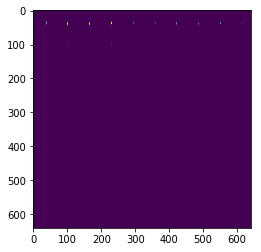

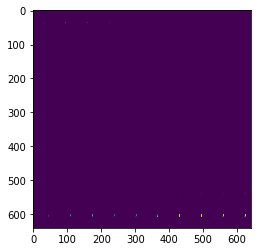

In [8]:
x1 = train_data[0, 0,:].reshape(1, 1, 64, 64)
x3 = train_data[0, 5,:].reshape(1, 1, 64, 64)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    z1 = encoder(x1)[0].array
    z3 = encoder(x3)[0].array
    z_seq = z1 + np.kron(np.linspace(0, 1, 100).astype(np.float32).reshape(100, 1, 1), (z3 - z1))
    x_seq = F.sigmoid(decoder(z_seq.reshape(100, 100))).array
    x_seq_img = x_seq.reshape(10, 10, 64, 64).transpose(0, 2, 1, 3).reshape(640, 640)

x_seq_img = np.clip(x_seq_img * 255, 0, 255).astype(np.uint8)
plt.imshow(x_seq_img)
plt.show()
Image.fromarray(x_seq_img).save('train_seq.png')

images = []
for idx, img in enumerate(x_seq):
        img = (img.reshape(64, 64) * 255).astype(np.uint8)
        img = Image.fromarray(img).convert('P')
        images.append(img)
images[0].save('train_seq_ani.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

x1 = test_data[0, 0,:].reshape(1, 1, 64, 64)
x3 = test_data[0, 5,:].reshape(1, 1, 64, 64)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    z1 = encoder(x1)[0].array
    z3 = encoder(x3)[0].array
    z_seq = z1 + np.kron(np.linspace(0, 1, 100).astype(np.float32).reshape(100, 1, 1), (z3 - z1))
    x_seq = F.sigmoid(decoder(z_seq.reshape(100, 100))).array
    x_seq_img = x_seq.reshape(10, 10, 64, 64).transpose(0, 2, 1, 3).reshape(640, 640)

x_seq_img = np.clip(x_seq_img * 255, 0, 255).astype(np.uint8)
plt.imshow(x_seq_img)
plt.show()
Image.fromarray(x_seq_img).save('test_seq.png')

images = []
for idx, img in enumerate(x_seq):
        img = (img.reshape(64, 64) * 255).astype(np.uint8)
        img = Image.fromarray(img).convert('P')
        images.append(img)
images[0].save('test_seq_ani.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

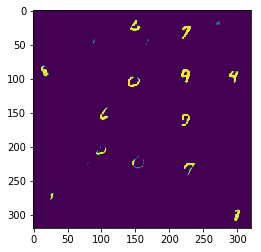

In [9]:
with chainer.using_config('train', False), chainer.no_backprop_mode():
    z = np.random.randn(25, 100).astype(np.float32)
    x = F.sigmoid(decoder(z)).array
    x = x.reshape(5, 5, 64, 64).transpose(0, 2, 1, 3).reshape(64*5, 64*5)

x = np.clip(x * 255, 0, 255).astype(np.uint8)
plt.imshow(x)
plt.show()
Image.fromarray(x).save('noise.png')